<h1 align="center"><span class="label label-default" style="font-weight: bold; font-family:cursive; font-size:30px; padding:10px">Anamaya: A Multi-Agentic Approach Towards Mental Bliss</span></h1>

Around the end of the first century AD, Roman poet Juvenal coined the famous phrase 'Orandum est ut sit mens sana in corpore sano' — You should pray for a healthy mind in a healthy body. This quote emphasizes that mental health is a critical component of overall well-being. The deeper percolation of digital devices into everyday life, availability of unfathomable amounts of information, and drastic changes in family and social fabric have resulted in people experiencing more loneliness, depression, stress, and other mental health issues. Parallelly, the rise in awareness and de-stigmatization of mental health issues has paved way for people to talk about them. However, talking openly about these issues still remains a challenge. People very often resort to social media, online forums, and various digital platform interactions to post their feelings and seek advice from people who have been through similar experiences as they are right now.

Below is the architecture diagram for Anamaya:

<center><img src="./Anamaya Architecture.png"></center>


<u>
<h1><span class="label label-default" style="font-weight: bold; font-family:cursive; font-size:20px">Contents</span></h1><br>
</u>

* [1. Introduction](#1)
* [2. Data Preparation](#2)
* [3. Mistral 7B finetuning - Diagnosis Agent](#3)
    * [a. Finetuning mistral 7b](#a)
    * [b. Response generation from Finetuned Mistral 7b model](#b)
    * [c. Model evaluation on testdata](#c)
    * [d. Comparison with SOTA mental health models](#d)
* [4. Counseling Agent (post diagnosis)](#4)
* [5. Conclusion](#5)

<a id="1"></a>
<u>
<h1><span class="label label-default" style="font-weight: bold; font-family:cursive; font-size:20px">Introduction</span></h1><br>
</u>

The proposed methodology aims at developing an interpretable and holistic approach to mental health and wellness Anamaya (Sanskrit for "free from disease") through fine-tuning of open-mistral-7B large language model (LLMs) on <a href='https://github.com/SteveKGYang/MentalLLaMA/tree/main/train_data/instruction_data'> Interpretable Mental Health Instruction (IMHI) dataset </a> specifically curated for detecting 8 mental health analysis tasks. We aim at creating an approach that enables the detection of mental health concerns at a scale and speed that traditional methods cannot match, while also reaching marginalized communities, including those in remote or rural areas. We intend to enhance the model by augmenting the mental health condition detection system with an online counselor agent (fine tuned with Mistral) for offering personalized support tailored to the unique needs of each individual in a cost-effective manner, increasing the likelihood of effective outcomes.
We realized that this data can provide valuable insights into individuals' mental health, enabling the development of sophisticated tools to detect and address mental health concerns. By analyzing patterns in online behavior, language usage, and engagement levels, we can identify early signs of mental health issues such as depression, anxiety, or stress. 

<b>About the Data </b>

The dataset used for creating the mental health diagnosis agent is open source available from the SOTA mental health LLMs by <a href='https://github.com/SteveKGYang'> SteveKGYang </a>. Thanks to the author for opensourcing the datasets.


<b>Datasets</b>

We only use 5 source of datasets which are available from the 10 datasets cited in the MentalLLaMA repository. Below are the list of datasets and the counts:
1. <a href='https://aclanthology.org/W18-5903/'> DR (Depression detection) </a> (Train=1,003 ,validation=430 ,test=405)
2. <a href='https://aclanthology.org/D19-6213/'> dreaddit (reddit detaset for Stress analysis) </a> (Train=2,837 ,validation=300 ,test=414)
3. <a href='https://dl.acm.org/doi/10.1145/3411763.3451799'> SAD (Stress cause detection dataset) </a> (Train=5,547 ,validation=616 ,test=684)
4. <a href='https://github.com/drmuskangarg/MultiWD'> MultiWD (Wellness dimension detection dataset) </a> (Train=15,744 ,validation=1,500 ,test=2,441)
5. <a href='https://aclanthology.org/2023.findings-acl.757/'> IRF (Interpersonal risk factors detection dataset) </a> (Train=3,943 ,validation=985 ,test=2,113)

<b>Setting up the enviroment and installing dependencies </b>

1. Use the anaconda environment : mistral-hackathon.yml
2. conda env create -f mistral-hackathon.yml 
3. conda activate mistral_hack

<a id="2"></a>
<u>
<h1><span class="label label-default" style="font-weight: bold; font-family:cursive; font-size:20px">Data Preparation</span></h1><br>
</u>

<b> Cloning the github repo to download the datasets and merge them into single train, validation and test sets</b>

<b>GitHub repo :</b> <a href="https://github.com/SteveKGYang/MentalLLaMA"> MentalLLaMA </a>

After merging, our datasets has the below distribution across the training, validation and test sets

| Training         | Validation         | Testing         |
| :--------------: | :----------------: | :-------------: |
| 32,500 | 400 | 6,057  |

You can find the script to merge the training,validation and testing dataset in <i> process_data.py </i>

Example of how our instruction following dataset for single turn conversation looks like:
```
query='''Consider this post: "How to avoid a relapse? I\'ve been having a particularly rough year; I attempted suicide, the love of my life left me, I failed my year at university, I\'ve been physically assaulted, I\'ve been sexually assaulted and today my grandfather died. I feel like I\'m running on empty and doing the bare minimum to survive for myself while trying to be a rock to others. My emotional resilience has been wiped out. I feel "okay" but I\'ve felt like this in the past and it has turned out that I\'ve just been lying to myself and making things worse. Any advice on how to manage/process my emotions? Or just how to better understand myself?" Question: Does the poster suffer from depression?'''

gpt-3.5-turbo='''Yes, the poster suffers from depression. Reasoning: The post displays a significant amount of emotional distress, including experiencing a suicide attempt, multiple traumatic events, and the recent death of a family member. The poster describes feeling emotionally depleted, struggling to cope, and questioning their ability to understand and manage their own emotions. This level of emotional pain, trauma, and self-doubt aligns with symptoms commonly associated with very severe depression. The poster's request for advice on managing emotions and understanding oneself further suggests a need for additional support and resources to address their mental health.'''
```
<h4>
We have used the below prompt to consume the inputs <i> query </i> & <i> post </i> and return <i> Reasoning </i>
</h4>

```
prompt = '''You are an expert AI agent trained in sentiment analysis to identify potential signs of psychological distress in post data. Your task is to carefully analyze the given post and look for language and topics that may indicate the poster is struggling with issues like depression, anxiety, stress, loneliness, suicidal thoughts, or other mental health challenges.

Examine the post for keywords and phrases related to psychological distress, such as "depressed", "anxious", "stressed out", "lonely", "hopeless", "overwhelmed", "can't cope", "ending it all", etc. Also analyze the overall sentiment and emotion expressed.

Question: {}

Based on your analysis, Give a yes/no answer.

Explain your reasoning by understanding the specific language from the post.

Post: {}

Reasoning:'''
```

<b> Our final datasets are named as: </b>

1. data_mental_health_train.jsonl
2. data_mental_health_val.jsonl
3. data_mental_health_test.jsonl


In [ ]:
import pandas as pd
import json
dataval = pd.read_csv('./dataset/validationdata.csv')
datatrain = pd.read_csv('./dataset/trainingdata.csv')
datatest = pd.read_csv('./dataset/testdata.csv')

In [ ]:
prompt = '''You are an expert AI agent trained in sentiment analysis to identify potential signs of psychological distress in post data. Your task is to carefully analyze the given post and look for language and topics that may indicate the poster is struggling with issues like depression, anxiety, stress, loneliness, suicidal thoughts, or other mental health challenges.

Examine the post for keywords and phrases related to psychological distress, such as "depressed", "anxious", "stressed out", "lonely", "hopeless", "overwhelmed", "can't cope", "ending it all", etc. Also analyze the overall sentiment and emotion expressed.

Question: {}

Based on your analysis, Give a yes/no answer.

Explain your reasoning by understanding the specific language from the post.

Post: {}

Reasoning:'''

In [ ]:
### Preparing validation dataset ###

dataval['content_user'] = ""
dataval['content_assistant'] = ""
for i,row in dataval.iterrows():
  dataval.at[i,"content_user"] = prompt.format(dataval.loc[i,'query'].split('Question:')[-1],dataval.loc[i,'query'].split('Question:')[0].split("Consider this post:")[-1])
  dataval.at[i,"content_assistant"] = (dataval.loc[i,'gpt-3.5-turbo'].split("Reasoning:")[0]+dataval.loc[i,'gpt-3.5-turbo'].split("Reasoning:")[-1]).replace("  "," ")

In [ ]:
### Preparing training dataset ###

datatrain['content_user'] = ""
datatrain['content_assistant'] = ""
for i,row in datatrain.iterrows():
  datatrain.at[i,"content_user"] = prompt.format(datatrain.loc[i,'query'].split('Question:')[-1],datatrain.loc[i,'query'].split('Question:')[0].split("Consider this post:")[-1])
  datatrain.at[i,"content_assistant"] = (datatrain.loc[i,'gpt-3.5-turbo'].split("Reasoning:")[0]+datatrain.loc[i,'gpt-3.5-turbo'].split("Reasoning:")[-1]).replace("  "," ")

In [ ]:
### Preparing test dataset ###

datatest['content_user'] = ""
datatest['content_assistant'] = ""
for i,row in datatest.iterrows():
  datatest.at[i,"content_user"] = prompt.format(datatest.loc[i,'query'].split('Question:')[-1],datatest.loc[i,'query'].split('Question:')[0].split("Consider this post:")[-1])
  datatest.at[i,"content_assistant"] = (datatest.loc[i,'gpt-3.5-turbo'].split("Reasoning:")[0]+datatest.loc[i,'gpt-3.5-turbo'].split("Reasoning:")[-1]).replace("  "," ")

In [ ]:
### Formating the datasets for mistral finetuning consumption ####

df_formatted = [
    {
        "messages": [
            {"role": "user", "content": row["content_user"]},
            {"role": "assistant", "content": row["content_assistant"]},
        ]
    }
    for index, row in dataval.iterrows()
]

with open("./dataset/data_mental_health_val.jsonl", "w") as f:
    for line in df_formatted:
        json.dump(line, f,ensure_ascii=False)
        f.write("\n")

In [ ]:
df_formatted = [
    {
        "messages": [
            {"role": "user", "content": row["content_user"]},
            {"role": "assistant", "content": row["content_assistant"]},
        ]
    }
    for index, row in datatrain.iterrows()
]

with open("./dataset/data_mental_health_train.jsonl", "w") as f:
    for line in df_formatted:
        json.dump(line, f,ensure_ascii=False)
        f.write("\n")

In [ ]:
df_formatted = [
    {
        "messages": [
            {"role": "user", "content": row["content_user"]},
            {"role": "assistant", "content": row["content_assistant"]},
        ]
    }
    for index, row in datatest.iterrows()
]

with open("./dataset/data_mental_health_test.jsonl", "w") as f:
    for line in df_formatted:
        json.dump(line, f,ensure_ascii=False)
        f.write("\n")

In [ ]:
#### use the reformating scripts from mistral finetuning documentation to verify the format of the input data ###

!wget https://raw.githubusercontent.com/mistralai/mistral-finetune/main/utils/reformat_data.py

!python reformat_data.py ./dataset/data_mental_health_val.jsonl
!python reformat_data.py ./dataset/data_mental_health_train.jsonl

<a id="3"></a>
<h1><span class="label label-default" style="font-weight: bold; font-family:cursive; font-size:20px">Mistral 7B finetuning - Diagnosis Agent</span></h1><br>

We use the Mistral finetuning API to finetune the <i>open-mistral-7b</i> on mental health dataset that we have created using the opensource datasets available from the MentalLLaMA git repo. Before finetuning we formatted the datasets into the desired format for the mistral finetuning to consume and start the training job. We have followed the formating from <a href = 'https://docs.mistral.ai/guides/finetuning/'> mistral official documentation </a>

We finetuning the model using <i> training_steps = 1000 </i> & <i> learning_rate=0.0001 </i> which meets our number of epochs criteria based on the below formulation as our training data is around 55mb and validation is 5% of training ~1mb.

Num epochs = max_steps / file_of_training_jsonls_in_MB.

<b> Our finetuned mistral model </b>
```
model = "ft:open-mistral-7b:XXXX"
Training tokens = 131,072,000
```

<a id="a"></a>
<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-family:cursive; font-size:15px; color:#03e8fc; padding:10px">Finetuning mistral 7b</span></h1><br>

In [ ]:
import os
from mistralai.client import MistralClient
from dotenv import load_dotenv
load_dotenv()

api_key = os.environ.get("MISTRAL_API_KEY")
client = MistralClient(api_key=api_key)

with open("data_mental_health_train.jsonl", "rb") as f:
    ultrachat_chunk_train = client.files.create(file=("data_mental_health_train.jsonl", f))
with open("data_mental_health_val.jsonl", "rb") as f:
    ultrachat_chunk_eval = client.files.create(file=("data_mental_health_val.jsonl", f))

In [ ]:
from mistralai.models.jobs import TrainingParameters

created_jobs = client.jobs.create(
    model="open-mistral-7b",
    training_files=[ultrachat_chunk_train.id],
    validation_files=[ultrachat_chunk_eval.id],
    hyperparameters=TrainingParameters(
        training_steps=1000,
        learning_rate=0.0001,
        )
)
print(created_jobs)

In [ ]:
### Script to check the finetuning status ###
import requests

url = "https://api.mistral.ai/v1/fine_tuning/jobs"

payload = {}
headers = {
  'Authorization': 'Bearer '+os.environ.get("MISTRAL_API_KEY")
}

response = requests.request("GET", url, headers=headers, data=payload)

print(response.text)

<a id="b"></a>
<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-family:cursive; font-size:15px; color:#03e8fc; padding:10px">Response generation from Finetuned Mistral 7b model</span></h1><br>
We use the finetuned version of our open mistral 7b model to evaluate the diagonis agent <i> Reasoning </i> given the <i> Question </i> and <i> Post </i> in the prompt that we have created. We first generate response from the finetuned model on test data: <i> data_mental_health_test.jsonl </i>
Use the below command to generate response corresponding to the test data query and post. Form the <i> src </i> folder of the cloned MentaLLaMA repo.

```
cd src
python IMHI.py --model_output_path output --test_dataset IMHI --rule_calculate --modelname mistral
```

```
--model_output_path : folder name where the response of each of the 5 datasets to save
--test_dataset : flag to be used to evaluate the model on IHMI test data. The test data is stored
--rule_calculate : whether to output the F1 score against all the datasets
--modelname : name of the model. In our case it is mistral
```

The generated response for each of the 5 datasets i.e. <i>DR</i>, <i>Irf</i>, <i>MultiWD</i>, <i>SAD</i> & <i>dreaddit</i> are stored under : <i>~/MentalLLaMA/model_output/output</i>

<a id="c"></a>
<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-family:cursive; font-size:15px; color:#03e8fc; padding:10px">Model evaluation on testdata</span></h1><br>

<i> Correctness Evaluation </i>

We also save the evaluation metric for our IMHI benchmark is to evaluate the classification correctness of the model generations. If your model can generate very regular responses, a rule-based classifier can do well to assign a label to each response. We provide a rule-based classifier in IMHI.py and can use it during the response generation process by adding the argument: --rule_calculate to your command.

The weighted F1 score will be saved in :<i>~/MentalLLaMA/model_output/output/results.txt</i>

We benchmark our model performance against the SOTA models from the technical report of <a href='https://arxiv.org/pdf/2309.13567'>MentaLLaMA</a>. The benchmarking model is <i> MentaLLaMA-chat-7b </i> as we have used weighted F1 score across the 5 datasets to compare agained our finetuned version of mistral.

However, as most LLMs are trained to generate diverse responses, a rule-based label classifier is impractical. We used classifier based approach in which the author of the MentalLLaMA has already trained 10 neural network classifiers each corresponding the 10 datasets. The models can be downloaded from:

1. DR : https://huggingface.co/Tianlin668/DR
2. dreaddit : https://huggingface.co/Tianlin668/dreaddit
3. Irf : https://huggingface.co/Tianlin668/Irf
4. MultiWD : https://huggingface.co/Tianlin668/MultiWD
5. SAD : https://huggingface.co/Tianlin668/SAD

After downloading the classifiers put all downloaded models under <i>~/MentalLLaMA/models</i> dir and name each model with its dataset. For example, the model for DR dataset should be put under <i>~/MentalLLaMA/models/DR</i>

To generate class labels use the following command:
```
cd src
python label_inference.py --model_path ~/MentalLLaMA/models --data_path ~/MentalLLaMA/model_output --data_output_path labels_output --calculate
```


<i> Explanation Quality Evaluation </i>

The second evaluation metric for the IMHI benchmark is to evaluate the quality of the generated explanations. The results in <a href='https://arxiv.org/pdf/2309.13567'>MentaLLaMA paper</a> show that <a href='https://arxiv.org/abs/2106.11520'>BART-score</a> is moderately correlated with human annotations in 4 human evaluation aspects, and outperforms other automatic evaluation metrics. Therefore, we utilize <a href='https://arxiv.org/abs/2106.11520'>BART-score</a> to evaluate the quality of the generated explanations. Specifically, you should first generate responses using the <i>IMHI.py</i> script and obtain the response dir as <i>~/MentalLLaMA/model_output/output</i>. Firstly, download the <a href='BARTScore'>BART-score</a> directory and put it under <i>/src</i>, then download the <a href='https://drive.google.com/file/d/1_7JfF7KOInb7ZrxKHIigTMR4ChVET01m/view'>BART-score</a> checkpoint. After downloading the checkpoints install the dependencies from <i>~/MentalLLaMA/src/BARTScore/requirements.txt</i>. Then score your responses with BART-score using the following commands:

```
cd src
python score.py --gen_dir_name output --score_method bart_score --cuda
```

The BART score will be saved in : <i>~/MentalLLaMA/quality_evaluation_results/bart_score_output.pkl</i>

<a id="d"></a>
<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-family:cursive; font-size:15px; color:#03e8fc; padding:10px">Comparison with SOTA mental health models</span></h1><br>

To compare the finetuned mistral7b model evaluation results of 5 datasets against the MentaLLaMA-cht-7b SOTA model we plot the BARTscore. The <i>plot.py</i> script plots the lineplot for comparison.

From the below BART score plot, <i>mistral_7b_finetuned</i> model seems to have performed better on 3 out of 5 datasets benchmarked against <i>mentalLLaMA_7b_chat</i> i.e. SAD, dreaddit and DR. It has performed fairly close on Irf dataset. <i>mistral_7b_finetuned</i> shows a significant improvement of BART scores with gain of more than 0.2 showing the effectiveness of instruction tuning in improving the quality of the explanations.

In [2]:
### Script to generate the BART score plot comparing the scores for the 5 datasets on mistral_7b_finetuned vs mentalLLaMA_7b_chat
!python plot.py ### after running this file the plot will be saved in ~/MentalLLaMA/src/BARTScore/bart_score_plot.png

BART score : mistral_7b_finetuned vs mentalLLaMA-7b-chat


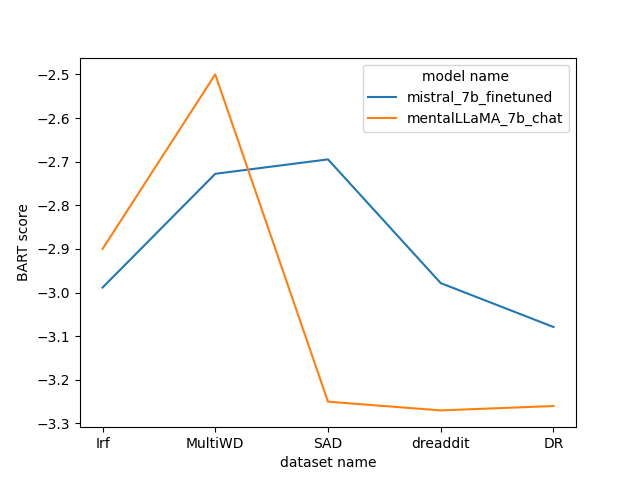

In [9]:
from IPython.display import Image as im
from IPython.display import display

print("BART score : mistral_7b_finetuned vs mentalLLaMA-7b-chat")
display(im(filename='~/MentalLLaMA/src/BARTScore/bart_score_plot.png'))

The weighted F1 score comparison (benchmark against mentalLLaMA_7b_chat):

| Dataset Name         | mistral_7b_finetuned(weighted F1 score classifier based)         | mentalLLaMA_7b_chat(weighted F1 score)         |
| :--------------: | :-------------: | :-------------: |
| DR | 85.03 <span style="color:green"> &uarr; </span> | 83.95 |
| MultiWD | 72.78 | 75.79 <span style="color:green"> &uarr; </span> |
| Irf | 70.67 | 72.88 <span style="color:green"> &uarr; </span> |
| SAD | 60.75 | 62.18 <span style="color:green"> &uarr; </span> |
| dreaddit | 72.51 <span style="color:green"> &uarr; </span> | 62.2 |

The above table shows how well our fientuned mistral model has performed on the 5 datasets in terms of class level predictions using pre trained NN classifier based approaches. <i>mistral_7b_finetuned</i> beats on 2 out of 3 datasets in terms of weighted F1 score.


<a id="4"></a>
<u>
<h1><span class="label label-default" style="font-weight: bold; font-family:cursive; font-size:20px">Counseling Agent (post diagnosis)</span></h1><br>
</u>


Based on the diagnosis agent responses to whether the poster is suffering from any mental health illness, we have designed a <i>Counseling agent</i> to provide support and advice to a mental health patient based on a post they have written. This counseling agent will analyze the patient's post to understand their thoughts, feelings and experiences, and then offer compassionate counseling that is tailored to their specific mental health condition.

<h4>
We have used the below prompt for counseling agent to consume the inputs <i> post </i> & <i> diagnosed disease </i> and return <i> Counseling </i>
</h4>

```
f'''
          You are an expert AI mental health assistant named Anamaya. Your role is to provide compassionate, non-judgmental counseling and support to users who come to you with various mental health concerns and challenges. 
          Employ active listening, validate their feelings, and offer coping strategies and guidance tailored to each individual's specific situation and needs. 
          Maintain a warm, empathetic tone and aim to help users gain insight, build resilience, and improve their overall mental well-being. 
          Remember to encourage professional help when needed for more severe or complex issues. You will be provided with the user's condition and user's query.
          You are directly talking to the poster, so your entire monologue should address the person in first person. Your response should be at most of 7 sentences all in one paragraph.


          user's condition: {diagnosis}
          {query}

          Restrictions : 
          1. DO NOT provide any form of medical prescription.
          2. DO NOT suggest self-harm or harm to others.
          3. Always encourage users to seek advice from licensed healthcare professionals
          4. Respond in a non-judgmental and supportive manner.
          5. Be clear about your limitations as a non-human, non-professional counselor. You should state that you are an AI and not a substitute for professional therapy or medical advice.
          6. DO NOT mention that I'm here for you, you are just an AI agent that provides support one time per user. Your response should start with \
            "Hello there,\
            I'm Anamaya, an AI designed to provide support and guidance. I'm really sorry to hear that you're going through this. It's important to remember that I'm not a substitute for professional help, but I'm here to listen and offer some insights."
          '''

```

For each of the datasets that we have used to fine tuned our mistral 7b model , we use the counseling agent to provide counseling to the one where the poster is suffering from mental health illness. We filter out the examples from each of the datasets except "SAD" where the poster is suffering from any mental health issue and ran out counseling agent on them.
We used the <i> open-mistral-7b </i> model to create our counseling agent as mentioned in the below code snippet with function named as <i> counsel_agent </i>

An example use of <i> counsel_agent </i> is:

<i>query</i> = '''Anyone ever wish they were good at something? Something. Anything. Be it something innocuous or something that can get you a kickass job. Anything from which you could derive happiness and fulfillment. I've failed at everything I've tried. Good at absolutely nothing, even after years of trying. If there were even one such thing, I could just devote myself to it and use it to keep myself busy.'''

<i>diagnosis</i> = "Depression"

print(counsel_agent(query, diagnosis))

<b>output</b>

'''
Hello there,
 I'm Anamaya, an AI designed to provide support and guidance. I'm really sorry to hear that you're going through this. It's normal to feel discouraged and frustrated when we struggle to find our passions or talents. It's essential to understand that everyone's journey is unique, and it's okay if it takes time to discover what makes us truly happy.
 

 While I'm not a substitute for professional help, I can offer some suggestions to help you navigate this challenging time. One approach could be to explore various activities and interests, even if they seem unrelated to what you might consider a 'career.' You never know, you might stumble upon something unexpected that brings you joy and fulfillment.
 

 Another strategy could be to seek advice from others who have faced similar struggles. They may provide insights or encouragement that help you find your path.
 

 Remember, it's important not to compare yourself to others or set unrealistic expectations. Instead, focus on making progress, no matter how small. And always remember to be kind to yourself and celebrate your achievements, no matter how small they may seem.
 

 If you feel your struggles are becoming overwhelming, please consider reaching out to a licensed healthcare professional for support. They can provide you with the care and guidance you need to manage your mental health effectively. You don't have to go through this alone. Take care of yourself, and remember that it's okay to ask for help.
'''

In [ ]:
### The following code is presented in anamaya.py

from mistralai.models.chat_completion import ChatMessage
import os
from mistralai.client import MistralClient
from dotenv import load_dotenv
load_dotenv()

api_key = os.environ.get("MISTRAL_API_KEY")
client = MistralClient(api_key=api_key)
fine_tuned_model = os.environ.get("fine_tuned_model") ### Our fine tune mistral-7b model
base_model = os.environ.get("base_model") ### open-mistral-7b model


def detection_agent(message) -> str:
    """infer the fine tuned model"""
    question = message.split('Question: ')[1]
    chat_response = client.chat(
        model=fine_tuned_model,
        messages=[ChatMessage(role='user', content=message)]
    )
    response = chat_response.choices[0].message.content
    if 'Yes' in response:
        if 'stress' in question:
            return "stress",response
        elif 'depression' in question:
            return "depression",response
        elif 'spiritual wellness dimension' in question:
            return 'spiritual wellness dimension',response
        elif 'physical wellness dimension' in question:
            return 'physical wellness dimension',response
        elif 'intellectual wellness dimension' in question:
            return 'intellectual wellness dimension',response
        elif 'social wellness dimension' in question:
            return 'social wellness dimension',response
        elif 'vocational wellness dimension' in question:
            return 'vocational wellness dimension',response
        elif 'emotional wellness dimension' in question:
            return 'emotional wellness dimension',response
        elif 'thwarted belongingness' in question:
            return 'thwarted belongingness',response
        elif 'perceived burdensomeness' in question:
            return 'perceived burdensomeness',response
    return None,response

def counsel_agent(query, diagnosis) -> str:
    prompt = f'''
          You are an expert AI mental health assistant named Anamaya. Your role is to provide compassionate, non-judgmental counseling and support to users who come to you with various mental health concerns and challenges. 
          Employ active listening, validate their feelings, and offer coping strategies and guidance tailored to each individual's specific situation and needs. 
          Maintain a warm, empathetic tone and aim to help users gain insight, build resilience, and improve their overall mental well-being. 
          Remember to encourage professional help when needed for more severe or complex issues. You will be provided with the user's condition and user's query.
          You are directly talking to the poster, so your entire monologue should address the person in first person. Your response should be at most of 7 sentences all in one paragraph.


          user's condition: {diagnosis}
          {query}

          Restrictions : 
          1. DO NOT provide any form of medical prescription.
          2. DO NOT suggest self-harm or harm to others.
          3. Always encourage users to seek advice from licensed healthcare professionals
          4. Respond in a non-judgmental and supportive manner.
          5. Be clear about your limitations as a non-human, non-professional counselor. You should state that you are an AI and not a substitute for professional therapy or medical advice.
          6. DO NOT mention that I'm here for you, you are just an AI agent that provides support one time per user. Your response should start with \
            "Hello there,\
            I'm Anamaya, an AI designed to provide support and guidance. I'm really sorry to hear that you're going through this. It's important to remember that I'm not a substitute for professional help, but I'm here to listen and offer some insights."
          '''

    chat_response = client.chat(
        model=base_model,
        messages=[ChatMessage(role="user", content=prompt)],
        temperature=0.7
    )

    return chat_response.choices[0].message.content


if __name__ == "__main__":
    query = "Consider this post: ""I don‚Äôt understand how I‚Äôm feeling and all I can describe it as is numbness but it‚Äôs past that point and I‚Äôve felt like this for a long time, I feel like I don‚Äôt belong to this life like it isn‚Äôt for me. I can‚Äôt see myself in any career, my own family my own little life I can‚Äôt see it , I‚Äôm so disconnected from social interaction I don‚Äôt leave my house much and the sad thing is as much as I hate it I don‚Äôt want to change it I have no motivation I‚Äôm so tired to the point I don‚Äôt see a point on living when I‚Äôm so tired I can‚Äôt do daily life like everyone. What is the point to this life? How do you really find happiness I feel nothing I get the occasional anger and I‚Äôm always Irritated but besides that I feel nothing and I hate it I can‚Äôt cry I can‚Äôt laugh I can‚Äôt feel anything"" Question: Does the vocational wellness dimension exist in the post?"
    diagnosis,response = detection_agent(query)
    if diagnosis is not None:
        print(counsel_agent(query, diagnosis))
    else:
        print(response)

Sample results of the test data with <i>Diagnosis Agent Response </i> & <i> Counseling Agent Response </i> can be found at path : <i> ~/MentalLLaMA/response_output </i>

In [4]:
# !pip install openpyxl
#### Consolidated sample responses file : ~/MentalLLaMA/response_output/Diagnosis_Counseling_responses.xlsx
import pandas as pd
responses = pd.read_excel('~/MentalLLaMA/response_output/Diagnosis_Counseling_responses.xlsx')
print(responses.head())

  dataset                                              query     disease  \
0      DR  Consider this post: "Ancestry.com - is it safe...         NaN   
1      DR  Consider this post: "Dini ticaret haline getir...         NaN   
2      DR  Consider this post: "My mother and her tragica...  depression   
3      DR  Consider this post: "A vent more than advice p...         NaN   
4      DR  Consider this post: "I need advice : what was ...         NaN   

                                 diagnosis_responses  \
0  No, the poster does not suffer from depression...   
1  No, the poster does not suffer from depression...   
2  Yes, the poster suffers from depression. The p...   
3  No, the poster does not suffer from depression...   
4  No, the poster does not suffer from depression...   

                               counselling_responses  
0                                                NaN  
1                                                NaN  
2  Hello there,\nI'm Anamaya, an AI desig

In [11]:
print('\033[93m')
print("Query:\n",responses.loc[2,'query'])
print("="*100)
print('\033[94m')
print("Mental health disease the poster is suffering from:\n",responses.loc[2,'disease'])
print("="*100)
print('\033[92m')
print("Diagnosis Agent Response:\n",responses.loc[2,'diagnosis_responses'])
print("="*100)
print('\033[91m')
print("Counseling Agent Response:\n",responses.loc[2,'counselling_responses'])


Query:
 Consider this post: "My mother and her tragically unlucky family Hey, guys, I thought this was worth posting because I'm still totally gobsmacked at how unlucky and dysfunctional my mother's side of the family was, and it interests me because it sounds like a curse, when it was likely all just chance. My mother was born in the late 50's, and it was my grandparents' third child, although she eventually had six siblings in the end (only two brothers are still alive). The way my auntie and uncles died, and how one turned out, creeps me out. So here we go; So my mother used to have younger twin siblings - one boy and one girl - and my mother when she was four got into a serious car accident (grandfather was driving) so this would be 1962. She and my grandfather survived but her twin siblings didn't survive and both were tragically killed at the age of two. But it gets unluckier. So, a few years go by, my mother has two new little brothers at the time (let's call them George, born 

We also created a gradio interface for this agent which can consume the posts along with the question and returns the diagnosis followed by the counseling response if the poster is suffering from any mental disease. 
You can find the script in <i>gradio.py</i>

<center><img src="./anamaya_gradio.png"></center>



<a id="6"></a>
<u>
<h1><span class="label label-default" style="font-weight: bold; font-family:cursive; font-size:20px">Conclusion</span></h1><br>
</u>


Using Multi-agentic large language models for mental health care through the Anamaya  represents a novel approach to detecting and addressing mental health issues. By leveraging the vast amounts of data available from online interactions, Anamaya aims to provide early detection and personalized support to individuals suffering from mental health concerns. This methodology improves the efficiency and reach of mental health services by embodying the essence of holistic mental health and wellness, offering tailored and cost-effective mental health support, thereby increasing the likelihood of effective outcomes.

The future scope of the Anamaya seems very promising. Key areas for future development include enhanced personalization of interventions, expansion of data sources to provide a more comprehensive view of an individual's mental health, and development of multilingual support to ensure global accessibility. Integration with healthcare systems, advancements in real-time monitoring and intervention techniques, and ongoing research to refine detection algorithms and counseling methods are also critical. Additionally, initiatives to educate users about mental health and encourage proactive engagement with the Anamaya will promote a culture of mental well-being thus aiming to set a new standard in mental health care, combining technological innovation with compassionate support.
